In [19]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import torch
from tqdm import tqdm

In [20]:
# The different imputation strategies
def half_min_imputer(X):
    M0 = pd.DataFrame(X)
    mins=M0.min(axis=1)/2
    for i,j in zip(np.where(np.isnan(M0))[0], np.where(np.isnan(M0))[1]):
        M0.iloc[i,j]=mins[i]
    return (M0.values)

In [21]:
def knn_imputer(X, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_imputed = imputer.fit_transform(X)
    return(X_imputed)

In [22]:
def als_imputer(X, l=20, regularization=10**2, iterations=100):
    W = np.isfinite(X)
    X = np.nan_to_num(X)
    X0, Y0 = run_weighted_als(X, W, l, iterations, regularization, X0='rnd', Y0='rnd', seed=0)
    X_imputed = np.matmul(X0.T, Y0)
    return(X_imputed)
    
def run_weighted_als(X,W,l,iterations,regularization, X0='rnd', Y0='rnd', seed=0):
    n0,n1=X.shape
    #X=torch.tensor(X).to_gpu()
    #W=torch.tensor(W).to_gpu()
    
    if str(type(X0))=="<class 'str'>" and str(type(Y0))=="<class 'str'>":
        np.random.seed(seed)
        X1=np.zeros((l,n0))
        Y0=np.random.rand(l,n1)
        Y1=np.zeros((l,n1))
    elif str(type(X0))=="<class 'str'>" or str(type(Y0))=="<class 'str'>":
        print('Please provide both X0 and Y0')
    else:
        X1=np.zeros((l,n0))
        Y1=np.zeros((l,n1))
        
    
    X=torch.tensor(X).cuda().float()
    W=torch.tensor(W).cuda().float()
    Y0=torch.tensor(Y0).cuda().float()
    
    
    for k in tqdm(range(iterations)):
        X0=iterate_gpu(n0, X, W, Y0, l, regularization, 0)
        Y0=iterate_gpu(n1, X, W, X0, l, regularization, 1)
    X0=X0.cpu().numpy()
    Y0=Y0.cpu().numpy()
        
    return(X0,Y0)

# All of them should be tensors
def iterate_gpu(n0, X, W, Y0, l, regularization, pos):
    X1=torch.zeros((l,n0)).cuda()
    l0=regularization*torch.diag(torch.ones(l)).cuda()
    for i in range(n0):
        #print(i)
        if pos==0:
            cd=W[i,:]
            pd=X[i,:]
        elif pos==1:
            cd=W[:,i]
            pd=X[:,i]
        
        cY0T=Y0.T * cd[:, np.newaxis]
        M=torch.matmul(Y0,cY0T)+l0
        b=torch.matmul(Y0,pd*cd)
        X1[:,i]=torch.linalg.solve(M,b)
    return(X1)

In [23]:
def impute_normal_down_shift_distribution(X ,column_wise=True, width=0.3, downshift=1.8, seed=2):
    unimputerd_dataframe = pd.DataFrame(X.T)
    """ 
    Performs imputation across a matrix columnswise
    https://rdrr.io/github/jdreyf/jdcbioinfo/man/impute_normal.html#google_vignette
    :width: Scale factor for the standard deviation of imputed distribution relative to the sample standard deviation.
    :downshift: Down-shifted the mean of imputed distribution from the sample mean, in units of sample standard deviation.
    :seed: Random seed
    
    """
    unimputerd_df = unimputerd_dataframe.iloc[:,2:]

    unimputerd_matrix = unimputerd_df.replace({pd.NA: np.nan}, inplace=True) #Added to modify pandas's NAN values into  numpy NAN values
    
    unimputerd_matrix = unimputerd_df.to_numpy()
    columns_names = unimputerd_df.columns
    rownames = unimputerd_df.index
    unimputerd_matrix[~np.isfinite(unimputerd_matrix)] = None
    main_mean = np.nanmean(unimputerd_matrix)
    main_std = np.nanstd(unimputerd_matrix)
    np.random.seed(seed = seed)
    def impute_normal_per_vector(temp:np.ndarray,width=width, downshift=downshift):
        """ Performs imputation for a single vector """
        if column_wise:
            temp_sd = np.nanstd(temp)
            temp_mean = np.nanmean(temp)
        else:
            # over all matrix
            temp_sd = main_std
            temp_mean = main_mean

        shrinked_sd = width * temp_sd
        downshifted_mean = temp_mean - (downshift * temp_sd) 
        n_missing = np.count_nonzero(np.isnan(temp))
        temp[np.isnan(temp)] = np.random.normal(loc=downshifted_mean, scale=shrinked_sd, size=n_missing)
        if n_missing > 0:
            print 
        return temp
    final_matrix = np.apply_along_axis(impute_normal_per_vector, 0, unimputerd_matrix)
    final_df = pd.DataFrame(final_matrix)
    final_df.index = rownames
    final_df.columns = columns_names

    final_df = pd.concat([unimputerd_dataframe.iloc[:,:2],final_df], axis=1) 
    
    return final_df.values.T

In [24]:
def eval_imputation_test(X, imputation_method = 'knn', eval_fr=0.05, n_neighbors=5, l=2, regularization=10**0, iterations=100):
    X0 = X.copy()
    wh0, wh1 = np.where(np.isfinite(X))
    dfw = pd.DataFrame({'wh0':wh0, 'wh1':wh1, 'vals':X[wh0, wh1]})
    dfw_test = dfw.sample(int(len(dfw)*eval_fr))
    
    i0s = list(dfw_test['wh0'])
    i1s = list(dfw_test['wh1'])
    X[i0s, i1s]=np.NaN
    
    if imputation_method=='knn':
        X_imputed_test = knn_imputer(X, n_neighbors=n_neighbors)
        #X_imputed_full = knn_imputer(X0, n_neighbors=n_neighbors)
    elif imputation_method=='als':
        X_imputed_test = als_imputer(X, l=l, regularization=regularization, iterations=iterations)
        #X_imputed_full = als_imputer(X0, l=l, regularization=regularization, iterations=iterations)
    elif imputation_method=='half_min':
        X_imputed_test = half_min_imputer(X)
        #X_imputed_full = half_min_imputer(X0)
    elif imputation_method=='lower_normal':
        X_imputed_test = impute_normal_down_shift_distribution(X)
        #X_imputed_full = impute_normal_down_shift_distribution(X0)
    elif imputation_method=='zeros':
        X_imputed_test = np.nan_to_num(X)
        #X_imputed_full = np.nan_to_num(X0)
        
    dfw_test['pred'] = X_imputed_test[i0s, i1s]

    return (X_imputed_test, dfw_test)

In [25]:
def rmse(a,b):
    return(np.sqrt(np.mean((a-b)**2)))

In [8]:
Path = '/home/icb/manuel.gander/Atl/data/'
M0 = pd.read_pickle(f'{Path}/M0_new.pkl')
M1 = pd.read_pickle(f'{Path}/M1_new.pkl')
fr = 0.5
M0 = M0[np.isfinite(M0).sum(1)>fr*M0.shape[1]].copy()
M1 = M1[np.isfinite(M1).sum(1)>fr*M1.shape[1]].copy()

# ALS

In [ ]:
# For phospho proteome

In [9]:
df0 = M0.copy()

In [10]:
# Get the best for als

imputation_method= 'als'

frames = []
for i in range(5):
    for regularization in [1e-1, 1, 1e1, 1e2]:
        for l in [2,5,10,20]:
            print(l)
            X_new, dfv = eval_imputation_test(df0.values.copy(), imputation_method = imputation_method, 
                                         eval_fr=0.05, l=l, regularization=regularization, iterations=20)
            p = scipy.stats.pearsonr(dfv['vals'], dfv['pred']).statistic
            rmse_val = rmse(dfv['vals'], dfv['pred'])
            dfv = pd.DataFrame({'pearsons':[p], 'RMSE':rmse_val, 'imputation_method':imputation_method, 'i':i, 'l':l,
                               'regularization':regularization})
            frames.append(dfv)
Df = pd.concat(frames, ignore_index=True)
Df.to_pickle('als_M0.pkl')

2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.07s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.02s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.11s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:24<00:00,  4.24s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.09s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.06s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.05s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:24<00:00,  4.21s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.05s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.06s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:26<00:00,  4.31s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:24<00:00,  4.21s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.03s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.02s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.12s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.12s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.99s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.97s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:24<00:00,  4.22s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.11s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.06s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.02s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.07s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.13s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.96s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.92s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.10s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.04s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.93s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.90s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.93s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.01s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.90s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.88s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.89s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.93s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.85s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.85s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.92s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.97s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.86s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.87s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.87s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.94s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.87s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.84s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.89s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.99s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.85s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.86s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.97s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.04s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.91s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.92s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.98s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.00s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.86s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.87s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.91s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.98s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.85s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.88s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.93s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.00s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.92s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.91s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.94s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.98s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.88s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.87s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.89s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.97s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.85s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.84s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.91s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.98s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.87s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.88s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.92s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.03s/it]


In [ ]:
# For full proteome

In [11]:
df0 = M1.copy()

In [12]:
# Get the best for als

imputation_method= 'als'

frames = []
for i in range(5):
    for regularization in [1e-1, 1, 1e1, 1e2]:
        for l in [2,5,10,20]:
            print(l)
            X_new, dfv = eval_imputation_test(df0.values.copy(), imputation_method = imputation_method, 
                                         eval_fr=0.05, l=l, regularization=regularization, iterations=20)
            p = scipy.stats.pearsonr(dfv['vals'], dfv['pred']).statistic
            rmse_val = rmse(dfv['vals'], dfv['pred'])
            dfv = pd.DataFrame({'pearsons':[p], 'RMSE':rmse_val, 'imputation_method':imputation_method, 'i':i, 'l':l,
                               'regularization':regularization})
            frames.append(dfv)
Df = pd.concat(frames, ignore_index=True)
Df.to_pickle('als_M1.pkl')

2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.66s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.65s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.65s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.65s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.57s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.73s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.60s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.65s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:35<00:00,  1.75s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.65s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.60s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.66s/it]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.60s/it]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


In [26]:
cmap0 = sns.dark_palette("#69d", reverse=False, as_cmap=True)
cmap1 = sns.dark_palette("#69d", reverse=True, as_cmap=True)

Text(0.5, 1.0, 'ATLANTiC-Phosphoproteome: Pearson Correlation')

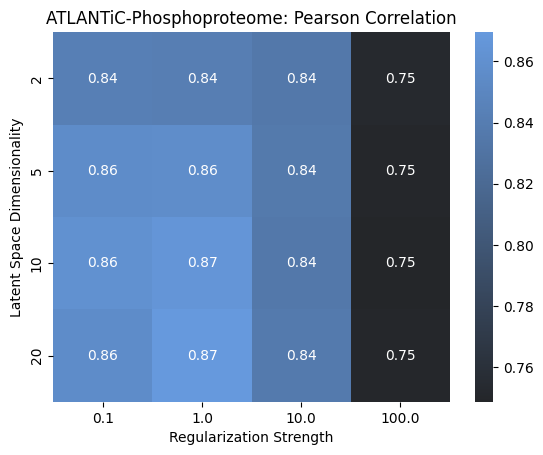

In [27]:
Df = pd.read_pickle('als_M0.pkl')
Dfn = Df.groupby(['regularization', 'l', 'imputation_method']).mean().reset_index()
sns.heatmap(Dfn.pivot(columns='regularization', index='l', values='pearsons'), cmap=cmap0, annot=True)
plt.title
plt.xlabel('Regularization Strength')
plt.ylabel('Latent Space Dimensionality')
plt.title('ATLANTiC-Phosphoproteome: Pearson Correlation')

Text(0.5, 1.0, 'ATLANTiC-Phosphoproteome: RMSE')

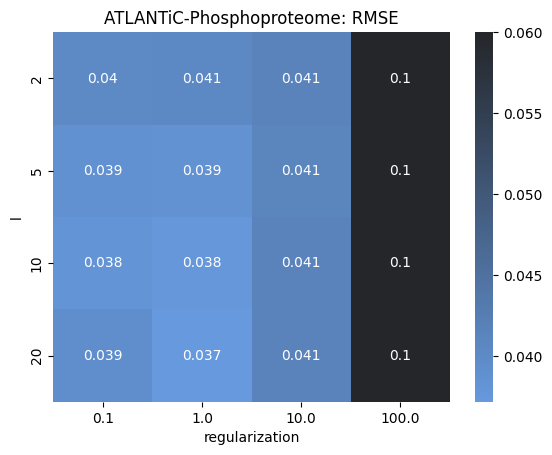

In [28]:
Df = pd.read_pickle('als_M0.pkl')

Dfn = Df.groupby(['regularization', 'l', 'imputation_method']).mean().reset_index()

sns.heatmap(Dfn.pivot(columns='regularization', index='l', values='RMSE'), cmap=cmap1, vmax=0.06, annot=True)
plt.title('ATLANTiC-Phosphoproteome: RMSE')

Text(0.5, 1.0, 'ATLANTiC-Full Proteome: Pearson Correlation')

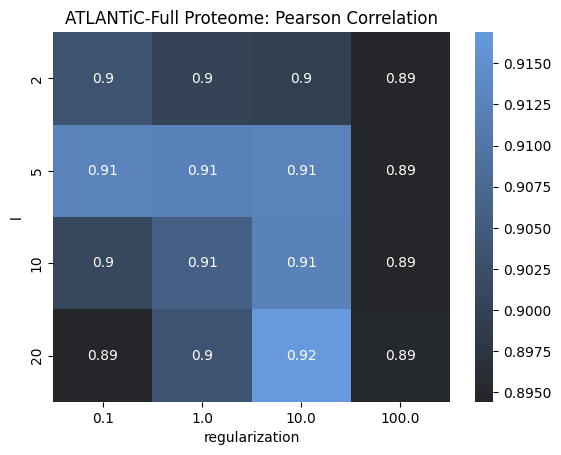

In [29]:
Df = pd.read_pickle('als_M1.pkl')
Dfn = Df.groupby(['regularization', 'l', 'imputation_method']).mean().reset_index()
sns.heatmap(Dfn.pivot(columns='regularization', index='l', values='pearsons'), cmap=cmap0, annot=True)
plt.title('ATLANTiC-Full Proteome: Pearson Correlation')

Text(0.5, 1.0, 'ATLANTiC-Full Proteome: RMSE')

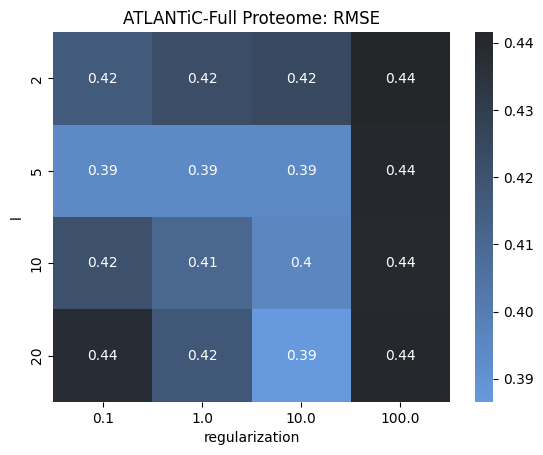

In [30]:
Df = pd.read_pickle('als_M1.pkl')
Dfn = Df.groupby(['regularization', 'l', 'imputation_method']).mean().reset_index()
sns.heatmap(Dfn.pivot(columns='regularization', index='l', values='RMSE'), cmap=cmap1, annot=True)
plt.title('ATLANTiC-Full Proteome: RMSE')